In [236]:
# Austin Corgan
# ASTR 400B Homework 5
# This program defines the MassProfile class and determines the mass
# distributions of galaxies and their rotation curves

from ReadFile import Read
from CenterOfMass import CenterOfMass
import numpy as np
import astropy.units as u
import astropy.table as tbl
from astropy.constants import G
import matplotlib
import matplotlib.pyplot as plt

G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)

In [280]:
class MassProfile:
    
    def __init__(self,galaxy,snap):
        # Initializes instances of class
        # Inputs:
        #    self - the particular instance of the class itself
        #    galaxy - a string with the galaxy name (MW, M31, M33)
        #    snap - snapshot number (0,1,2,...)
        
        # to reconstruct filename,
        # add a string of the filenumber to the value '000'
        ilbl = '000' + str(snap)
        # remove all but the last 3 digits 
        ilbl = ilbl[-3:]
        self.filename="%s_"%(galaxy) + ilbl + '.txt'
        
        # read in time in Myr, total number of particles, and data array 
        self.time, self.total, self.data = Read(self.filename)
        
        # read in data from data array for x,y,z positions and mass
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
        self.m = self.data['m']
        
        # store name of galaxy as global property 
        self.gname = galaxy
        
        
        # Function to compute the mass enclosed within a given radius 
        # of the COM position for a specified galaxy and specified
        # component of that galaxy 
        
    def MassEnclosed(self,ptype,radii):
            # Function to compute the mass enclosed within a given radius 
            # of the COM position for a specified galaxy and specified
            # component of that galaxy 
            # Inputs:
            #    ptype - particle type (1=dark matter, 2=disk, 3=bulge)
            #    adii - array of radii (kpc)
            # Returns: 
            #    array of masses (solMass) enclosed at corresponding 
            #    radii of input radii array 
            
            # determine COM position by creating CenterOfMass object 
            COM = CenterOfMass(self.filename,2)
            COMP = COM.COM_P(0.1) # input to COM_P is delta 
            
            # shift frame to have COM as origin
            # COMP is an array with components of COM (x,y,z)
            xnew = self.x - COMP[0]
            ynew = self.y - COMP[1]
            znew = self.z - COMP[2]
            
            # get magnitude of distance of particles from COM
            r = np.sqrt(xnew**2+ynew**2+znew**2)
            
            # initialize mass array with zeros equal to the number of 
            # elements in the input range array
            mass = np.zeros(len(radii))
            
            # obtain index over particles of given type
            index1 = np.where(self.data['type']==ptype)
            
            # loop over radius array, determining mass enclosed at each 
            # radius and making a corresponding array of enclosed masses 
            for i in range(len(radii)):
                # index over particles within given radius
                index2 = np.where(r < radii[i]*u.kpc)
                # take intersection of index1 and index2 to get index 
                # where particles are both of given type and within 
                # given radius 
                index3 = np.intersect1d(index1,index2)
                # sum over all values of mass for desired particles,
                # place in position in array corresponding to input radii
                # positions
                mass[i] = self.m[index3].sum()
            return mass*1e10*u.solMass
    
    # this function will compute the total mass enclosed as a function of radius 
    # considering all particle types
    
    def MassEnclosedTotal(self,radii):
        # Inputs:
        #    radii - array of radii (kpc) 
        # Returns:
        #    array of total mass enclosed within the corresponding radii in the input array 
        #    considering all particle types
        
        # Call MassEnclosed function to get mass enclosed for each particle type, then sum
        masshalo = self.MassEnclosed(1,radii)
        massdisk = self.MassEnclosed(2,radii)
        
        # account for the fact that M33 has no bulge
        if self.gname != 'M33':
            massbulge = self.MassEnclosed(3,radii)
            totalmass = masshalo + massdisk + massbulge 
        else:
            totalmass = masshalo + massdisk       
        return totalmass
    
    
    # this function will compute the mass enclosed at a given radius using the 
    # theoretical Hernquist Profile, which is 
    # rho(r) = M*a/(2*pi*r)*1/(r+a)^3
    # M(r) = Mhalo*r^2/(a+r)^2
    
    def HernquistMass(self,r,a,Mhalo):
        # Inputs:
        #    r - radius (kpc)
        #    a - scale factor (kpc)
        #    Mhalo - total mass of the dark matter halo (1e12 solMass)
        # Returns: 
        #    Mass enclosed at a the given radius (solMass)
        return Mhalo*r**2/(a+r)**2*1e12*u.solMass
    
    # this function will give the circular velocity as a function of radius for a single 
    # particle type based on the mass enclosed of that particle type at a particular radius
    # Use Newton's Second Law with gravitational force: 
    # GMm/r^2 = mv^2/r
    # v = sqrt(GM/r)
    
    def CircularVelocity(self,ptype,radii):
        # Inputs: 
        #    ptype - particle type (1 = dark matter halo, 2 = disk, 3 = bulge)
        #    radii - array of radii (kpc)
        # Returns: 
        #    array of circular speeds (km/s) corresponding to input radii array 
        
        # Get mass enclosed of specific particle type using MassEnclosed function
        M = self.MassEnclosed(ptype,radii)
        return np.round(np.sqrt(G*M/radii/u.kpc),2)
    
    # this function will give the total circular velocity as a function of radius due 
    # to all galaxy components in a similar manner to CircularVelocity function
    
    def CircularVelocityTotal(self,radii):
        # Inputs:
        #    radii - array of radii (kpc)
        # Returns:
        #    array of circular speeds (km/s) corresponding to input radii array 
        
        # Get total mass enclosed using MassEnclosedTotal
        M = self.MassEnclosedTotal(radii)
        return np.round(np.sqrt(G*M/radii/u.kpc),2)
    
    # this function will calculate the circular speed using the mass enclosed found with 
    # the Hernquist Mass Profile. Speed is calculated similarly to previous two functions
    
    def HernquistVCirc(self,r,a,Mhalo):
        # Inputs:
        #    r - radius (kpc)
        #    a - scale factor (kpc)
        #    Mhalo - total mass of dark matter halo (1e12 Msun)
        # Returns:
        #    Circular speed based on mass enclosed found using Hernquist profile (km/s)
        
        # Get mass enclosed as predicted by Hernquist profile by calling HernquistMass
        M = self.HernquistMass(r,a,Mhalo)
        return np.round(np.sqrt(G*M/r/u.kpc))

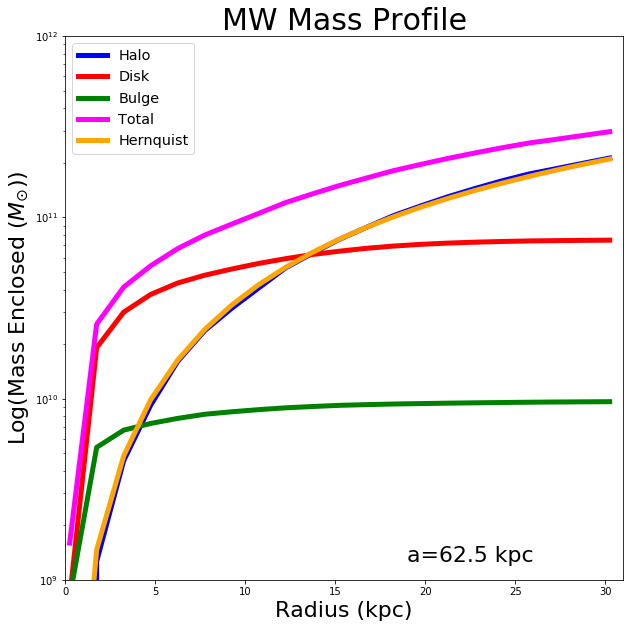

In [290]:
# Plot mass profiles for MW

# Define MW as instance of MassProfile class
MW = MassProfile('MW',0)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Create array to use as x-axis
r = np.arange(0.25,30.5,1.5)

# Plot mass enclosed vs. radius for each type of particle
ax.semilogy(r,MW.MassEnclosed(1,r),color='blue',linewidth=5,label='Halo')
ax.semilogy(r,MW.MassEnclosed(2,r),color='red',linewidth=5,label='Disk')
ax.semilogy(r,MW.MassEnclosed(3,r),color='green',linewidth=5,label='Bulge')

# Plot total mass enclosed vs. radius
ax.semilogy(r,MW.MassEnclosedTotal(r),color='magenta',linewidth=5,label='Total')

# Plot best fitting Hernquist profile 
# Use total dark matter mass of galaxy as found in Homework 3 (1e12 Msun)
MHaloMW = 1.975
ax.semilogy(r,MW.HernquistMass(r,62.5,MHaloMW),color='orange',linewidth=5,label='Hernquist')

# Add chart title 
plt.title('MW Mass Profile',fontsize=30)

# Add axis labels
plt.xlabel('Radius (kpc)',fontsize=22)
plt.ylabel('Log(Mass Enclosed ($M_{\odot}$))',fontsize=22)

# set axis limits
plt.xlim(0,31)
plt.ylim(1e9,1e12)

# Add text indicating best fit Hernquist profile scale length
plt.figtext(0.6,0.15,'a=62.5 kpc',fontsize=22)

# add a legend
legend = ax.legend(loc='upper left',fontsize='x-large')

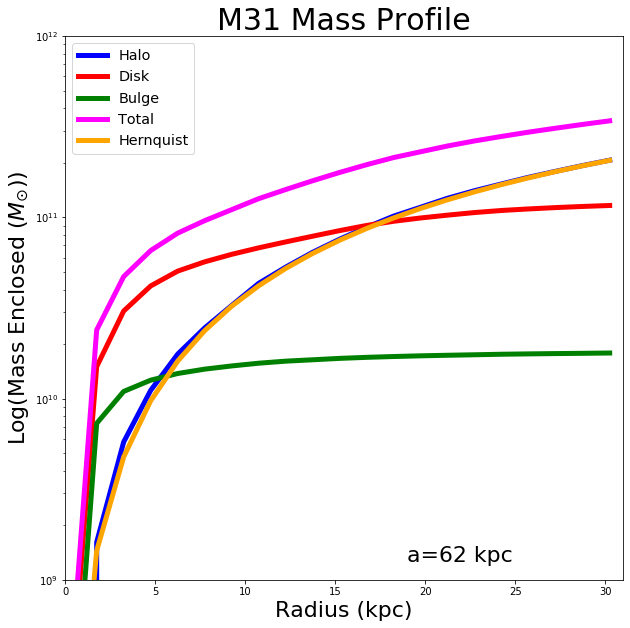

In [289]:
# Plot mass profiles for M31

# Define M31 as instance of MassProfile class
M31 = MassProfile('M31',0)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Create array to use as x-axis
r = np.arange(0.25,30.5,1.5)

# Plot mass enclosed vs. radius for each type of particle
ax.semilogy(r,M31.MassEnclosed(1,r),color='blue',linewidth=5,label='Halo')
ax.semilogy(r,M31.MassEnclosed(2,r),color='red',linewidth=5,label='Disk')
ax.semilogy(r,M31.MassEnclosed(3,r),color='green',linewidth=5,label='Bulge')

# Plot total mass enclosed vs. radius
ax.semilogy(r,M31.MassEnclosedTotal(r),color='magenta',linewidth=5,label='Total')

# Plot best fitting Hernquist profile 
# Use total dark matter mass of galaxy as found in Homework 3 (1e12 Msun)
MHaloM31 = 1.921
ax.semilogy(r,M31.HernquistMass(r,62,MHaloM31),color='orange',linewidth=5,label='Hernquist')

# Add chart title 
plt.title('M31 Mass Profile',fontsize=30)

# Add axis labels
plt.xlabel('Radius (kpc)',fontsize=22)
plt.ylabel('Log(Mass Enclosed ($M_{\odot}$))',fontsize=22)

# set axis limits
plt.xlim(0,31)
plt.ylim(1e9,1e12)

# Add text indicating best fit Hernquist profile scale length
plt.figtext(0.6,0.15,'a=62 kpc',fontsize=22)

# add a legend
legend = ax.legend(loc='upper left',fontsize='x-large')

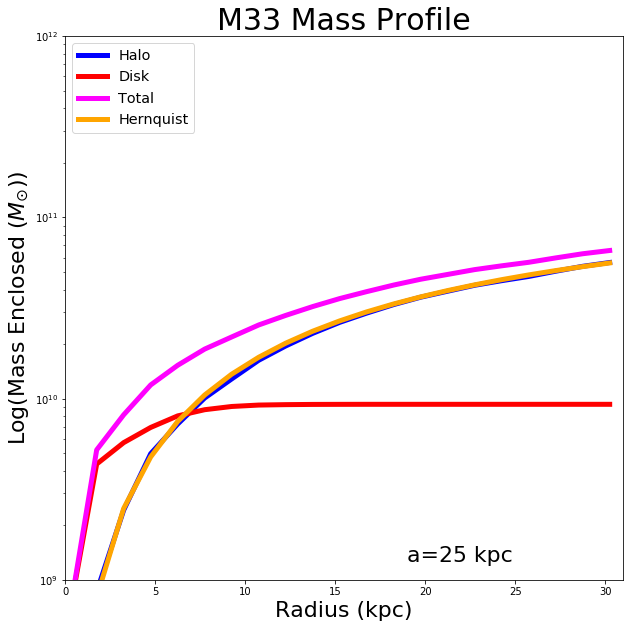

In [288]:
# Plot mass profiles for M33

# Define M33 as instance of MassProfile class
M33 = MassProfile('M33',0)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Create array to use as x-axis
r = np.arange(0.25,30.5,1.5)

# Plot mass enclosed vs. radius for each type of particle
ax.semilogy(r,M33.MassEnclosed(1,r),color='blue',linewidth=5,label='Halo')
ax.semilogy(r,M33.MassEnclosed(2,r),color='red',linewidth=5,label='Disk')

# Plot total mass enclosed vs. radius
ax.semilogy(r,M33.MassEnclosedTotal(r),color='magenta',linewidth=5,label='Total')

# Plot best fitting Hernquist profile 
# Use total dark matter mass of galaxy as found in Homework 3 (1e12 Msun)
MHaloM33 = 0.187
ax.semilogy(r,M33.HernquistMass(r,25,MHaloM33),color='orange',linewidth=5,label='Hernquist')


# Add chart title 
plt.title('M33 Mass Profile',fontsize=30)

# Add axis labels
plt.xlabel('Radius (kpc)',fontsize=22)
plt.ylabel('Log(Mass Enclosed ($M_{\odot}$))',fontsize=22)

# set axis limits
plt.xlim(0,31)
plt.ylim(1e9,1e12)

# Add text indicating best fit Hernquist profile scale length
plt.figtext(0.6,0.15,'a=25 kpc',fontsize=22)

# add a legend
legend = ax.legend(loc='upper left',fontsize='x-large')

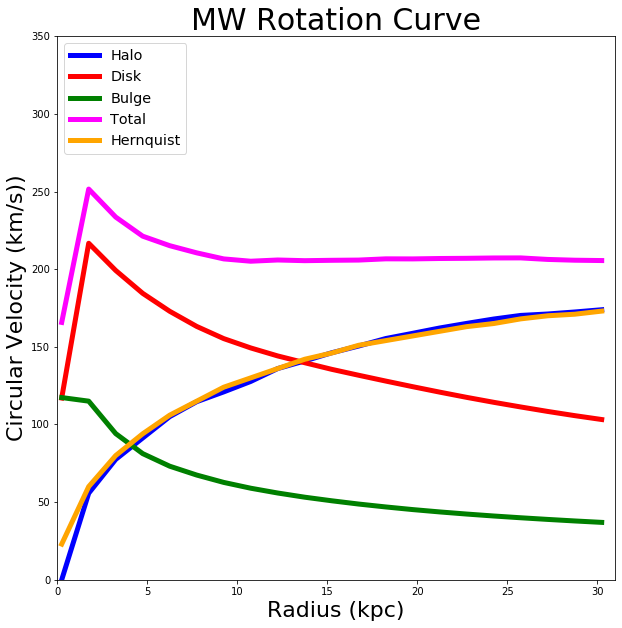

In [293]:
# Plot rotation curve for MW
 
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Create array to use as x-axis
r = np.arange(0.25,30.5,1.5)

# Plot rotation curve for each type of particle
plt.plot(r,MW.CircularVelocity(1,r),color='blue',linewidth=5,label='Halo')
plt.plot(r,MW.CircularVelocity(2,r),color='red',linewidth=5,label='Disk')
plt.plot(r,MW.CircularVelocity(3,r),color='green',linewidth=5,label='Bulge')

# Plot total circular velocity rotation curve
plt.plot(r,MW.CircularVelocityTotal(r),color='magenta',linewidth=5,label='Total')

# Plot rotation curve from best fitting Hernquist profile 
# Use total dark matter mass of galaxy as found in Homework 3 (1e12 Msun)
MHaloMW = 1.975
plt.plot(r,MW.HernquistVCirc(r,62.5,MHaloMW),color='orange',linewidth=5,label='Hernquist')

# Add chart title 
plt.title('MW Rotation Curve',fontsize=30)

# Add axis labels
plt.xlabel('Radius (kpc)',fontsize=22)
plt.ylabel('Circular Velocity (km/s))',fontsize=22)

# set axis limits
plt.xlim(0,31)
plt.ylim(0,350)


# add a legend
legend = ax.legend(loc='upper left',fontsize='x-large')

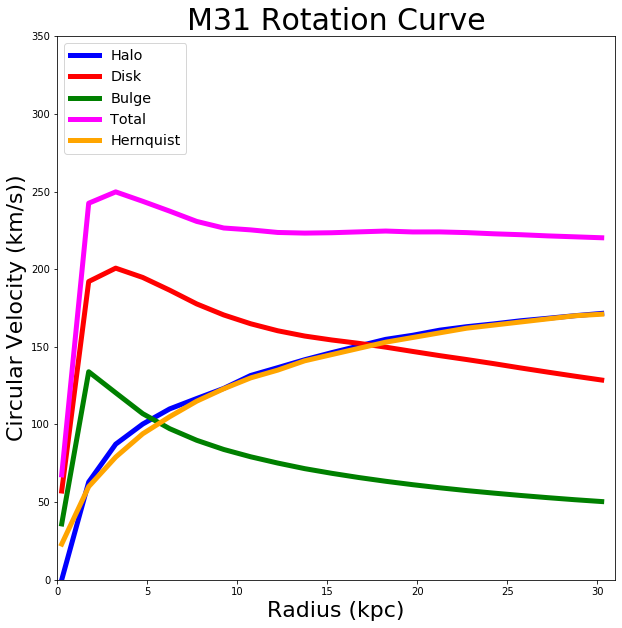

In [291]:
# Plot rotation curve for M31
 
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Create array to use as x-axis
r = np.arange(0.25,30.5,1.5)

# Plot rotation curve for each type of particle
plt.plot(r,M31.CircularVelocity(1,r),color='blue',linewidth=5,label='Halo')
plt.plot(r,M31.CircularVelocity(2,r),color='red',linewidth=5,label='Disk')
plt.plot(r,M31.CircularVelocity(3,r),color='green',linewidth=5,label='Bulge')

# Plot total circular velocity rotation curve
plt.plot(r,M31.CircularVelocityTotal(r),color='magenta',linewidth=5,label='Total')

# Plot rotation curve from best fitting Hernquist profile 
# Use total dark matter mass of galaxy as found in Homework 3 (1e12 Msun)
MHaloM31 = 1.921
plt.plot(r,M31.HernquistVCirc(r,62,MHaloM31),color='orange',linewidth=5,label='Hernquist')

# Add chart title 
plt.title('M31 Rotation Curve',fontsize=30)

# Add axis labels
plt.xlabel('Radius (kpc)',fontsize=22)
plt.ylabel('Circular Velocity (km/s))',fontsize=22)

# set axis limits
plt.xlim(0,31)
plt.ylim(0,350)


# add a legend
legend = ax.legend(loc='upper left',fontsize='x-large')

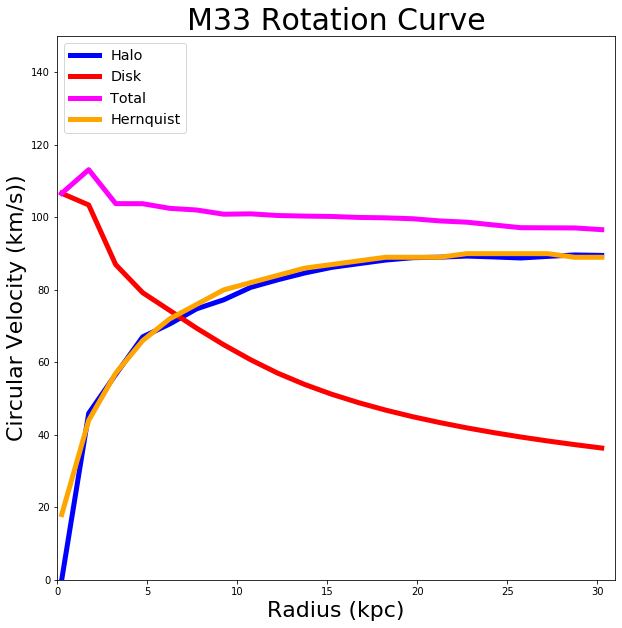

In [296]:
# Plot rotation curve for M33
 
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Create array to use as x-axis
r = np.arange(0.25,30.5,1.5)

# Plot rotation curve for each type of particle
plt.plot(r,M33.CircularVelocity(1,r),color='blue',linewidth=5,label='Halo')
plt.plot(r,M33.CircularVelocity(2,r),color='red',linewidth=5,label='Disk')

# Plot total circular velocity rotation curve
plt.plot(r,M33.CircularVelocityTotal(r),color='magenta',linewidth=5,label='Total')

# Plot rotation curve from best fitting Hernquist profile 
# Use total dark matter mass of galaxy as found in Homework 3 (1e12 Msun)
MHaloM33 = 0.187
plt.plot(r,M33.HernquistVCirc(r,25,MHaloM33),color='orange',linewidth=5,label='Hernquist')

# Add chart title 
plt.title('M33 Rotation Curve',fontsize=30)

# Add axis labels
plt.xlabel('Radius (kpc)',fontsize=22)
plt.ylabel('Circular Velocity (km/s))',fontsize=22)

# set axis limits
plt.xlim(0,31)
plt.ylim(0,150)


# add a legend
legend = ax.legend(loc='upper left',fontsize='x-large')